In [52]:
#Load and activate packages
using Pkg 
Pkg.activate("..")
Pkg.instantiate()

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


In [50]:
#Files we need
using Revise
if (!("../src" ∈ LOAD_PATH))
  push!(LOAD_PATH, "../src") 
end
using PharmacyEntry

In [5]:
# download website

using HTTP, Gumbo, Cascadia
r =  HTTP.get("http://www.bcpharmacists.org/list-community-pharmacies");  

# parse website into tree using Gumbo.jl
h = Gumbo.parsehtml(String(r.body));

# select elements by CSS with Cascadia
rows = eachmatch(Cascadia.Selector("tr.odd, tr.even"), h.root);
@show length(rows)
@show typeof(rows)
@show typeof(rows[1])
display(rows[1])
display(rows[1].children);


HTMLElement{:tr}:
<tr class="odd">
  <td>
    108 STOP PHARMACY
  </td>
  <td>
    13444 108 Ave
    Surrey, BC  V3T 2K1
    CANADA
  </td>
  <td>
    Moheb Michael
  </td>
  <td>
    (604) 957-0711
  </td>
  <td>
    (604) 953-1700
  </td>
</tr>


5-element Array{HTMLNode,1}:
 HTMLElement{:td}:
<td>
  108 STOP PHARMACY
</td>
                           
 HTMLElement{:td}:
<td>
  13444 108 Ave
  Surrey, BC  V3T 2K1
  CANADA
</td>

 HTMLElement{:td}:
<td>
  Moheb Michael
</td>
                               
 HTMLElement{:td}:
<td>
  (604) 957-0711
</td>
                              
 HTMLElement{:td}:
<td>
  (604) 953-1700
</td>
                              

length(rows) = 1358
typeof(rows) = Array{HTMLNode,1}
typeof(rows[1]) = HTMLElement{:tr}


In [6]:
###Put Data into a workable data Frame###
#This will create rows that are the corresponding columns on 
#the webpage we are gathering the data from. 

using DataFrames
function parserow(row)
  fields = nodeText.(row.children)
  fields = reshape(fields, (1, length(fields)))
end
txt = vcat(parserow.(rows)...)

#create the new dataframe to use
bc = DataFrame(txt, [:name, :address, :manager, :phone, :fax])
describe(bc);

In [7]:
##Extract information we want using regular expressions

bc[:street] = (a->replace(a, r"(.+)\n.+, BC.+\n.+"s => s"\1")).(bc[:address])
bc[:city]   = (a->replace(a, r".+\n(.+), BC.+\n.+"s => s"\1")).(bc[:address])
bc[:zip]  =     (a->replace(a, r".+(\p{L}\d\p{L}).?(\d\p{L}\d).*"s => s"\1 \2")).(bc[:address])
bc[:zipalt]    = (a->replace(a, r".+(\p{L}\d\p{L} \d\p{L}\d).*"s => s"\1")).(bc[:address])
bc[:province] = "BC" 
describe(bc);

### Problem 1: Compare zip and zipalt
The second one requires that there is a space between the first block of three characters 
and the second block of three characters whereas the first one does not. It is possible
that the postal codes on websites we are parsing from do not have spaces in them, in which
case zipalt would not pick them up. For example, if the postal code as listed as K0A2W0 with
no space, then zipalt would not match sinc eit requires a space. 

In [ ]:
#Compare :zip and :zipalt
#bc[:zip]  = (a->replace(a,r".+(\p{L}\d\p{L}).?(\d\p{L}\d).*"s => s"\1 \2")).(bc[:address]);
#bc[:zipalt] = (a->replace(a, r".+(\p{L}\d\p{L} \d\p{L}\d).*"s => s"\1")).(bc[:address]);


### Problem 2: Parse and additional Province (NB)

In [13]:
#Here I will be collecting data on New Brunswick Pharmacies. laodNBdata is in the 
#pharmacies.jl file but I'll show it here as well. 

function loadNBdata(redownload=false)
  csvfile=normpath(joinpath(@__DIR__,"..","data","nb-pharmacies.csv"))
    
  if (redownload || !isfile(csvfile))  
    nb = 1 
        #Since New Brunswicks has their pharmacy list spanning 5 different pages, we will need to make a loop 
        #that cycles through all 5 pages to get all the data we want. 
    for i = 1:5 
        web = string("https://www.nbpharmacists.ca/client/roster/clientRosterView.html?clientRosterId=208&page=", i)
        r =  HTTP.get(web) ; #Pulls from the web
        h = parsehtml(String(r.body)); #Puts into strings then cuts it into segments
    
        rows = eachmatch(Selector("div > div > table > tbody"),h.root); #tree path to get at the text we want
        println(size(rows))
        rows = rows[2:length(rows)]; # first one is empty
        function parserowNB(row)
            name = nodeText(row.children[1].children[1].children[1].children[1].children[1]) #Each of these will pick out the exact row you want from each Tbody
            manager = nodeText(row.children[1].children[1].children[2].children[2])
            phone = nodeText(row.children[1].children[2].children[4].children[2])
            fax = nodeText(row.children[1].children[2].children[4].children[5])
            street = nodeText(row.children[1].children[2].children[2])
            city_prov_zip = nodeText(row.children[1].children[2].children[3])
            address = string(street, city_prov_zip)
            txt = [name manager phone fax street city_prov_zip address]
        end
        
        n = DataFrame(vcat(parserowNB.(rows)...),
                   [:name, :manager, :phone, :fax, :street, :city_prov_zip, :address])
        n[:city]   = (a->replace(a, r"(.+) NB .+"s => s"\1")).(n[:city_prov_zip])
        n[:zip]  =     (a->replace(a,r".+ NB (.+)" => s"\1")).(n[:city_prov_zip])
        n[:province] = "NB" 
        delete!(n, :city_prov_zip) #align with Manitoba and BC
        
        #Code to append scraped data from the latest iteration to the dataframe    
        if nb == 1
           nb = n
        else nb = vcat(nb,n)
        end
            
     end 
        
    CSV.write(csvfile,nb)
          
  else
    nb = CSV.read(csvfile)
  end
  return(nb)
end

loadNBdata (generic function with 2 methods)

In [3]:
#Just checking that they are all formatted the same way

nb = PharmacyEntry.loadNBdata(false);
bc = PharmacyEntry.loadBCdata(false);
mb = PharmacyEntry.loadMBdata(false); 

nbbcmb = vcat(bc,mb,nb);
bcmb = vcat(bc,mb);

### Problem 3: Market Definition 

Based on the various definitions of geographic area defined by Statistics Canada, I do think that opulation centre is the most appropriate. Although, I am still not convinced that this is necessairily ideal for what we are trying to show. We are arguing that all pharmacies in the same population centre compete with one another, however this will not be the case for larger population centres. For instance, Vancouver itself is one population centre, but pharmacies in Delta don't actually compete with pharmacies in West Vancouver. Demand for pharmeceutical drugs is fairly inelestic in general, so when a consumer is deciding where to pick up there perscriptions, they will likley just go to the pharmacy that is closest. Just because a pharmacy in Delta has a slightly lower price, this doesn't mean that a consumer would drive an hour and a half to get the deal. Most Canadians have insurance for perscriptions anyways, so this just adds to the inelasticity. Maybe a better measure of 'pharmacies that compete' would be neighbourhood, at least in large population centres. We could potnetially use the first 3 character of the zip code to group pharmacies into neighbourhoods. 

In [8]:
#Create new variable for competeing neighbourhood
#Maybe use later?

nb[:neighbourhoods]  = (a->replace(a,r".+(\p{L}\d\p{L}).?(\d\p{L}\d).*"s => s"\1")).(nb[:address]);

### Problem 4: Geocoding New Brunswick

In [4]:
#tried very hard but couldnt get the geocoding to work for nb

using Statistics
allProv = PharmacyEntry.loadpharmacydata()
census = PharmacyEntry.loadcensusdata()

checklatlng!(allProv, :lat, :lng, :zip)
@show mean(allProv[:zipmatch])

reading pharmacy data from /home/jupyter/PharmacyEntry/data/pharmacies.csv


┌ Info: reading cleaned census data from /home/jupyter/PharmacyEntry/data/popcentres.csv
└ @ PharmacyEntry /home/jupyter/PharmacyEntry/src/census.jl:145


mean(allProv[:zipmatch]) = 0.6256921373200443


0.6256921373200443

### Problem 5: assign pharmacies to markets

So here we want to match each pharmacy to a population centre. Our data in cencus has logitude and latitude of population centres, while our data in allProv has logitude and latidue data for pharmacies. So we can make a function that matches each pharmacy to its corresponding population centre. I believe that the papaer says that pharmacies within 100km of a population centre belong to that population centre, so sticking with this convention Im going to write a function that assigns pharmacies to population centres that are within 1 degree of longitute and 1 degree of latititude (which is roughly 100km).

In [5]:
subset = (x->x ∈ ["British Columbia",
                  "Manitoba",
                  "Manitoba/Saskatchewan"]).(census[:PROV_TERR_NAME_NOM] )
df = census[subset,:]
    
    df[:pharmacies] = 0
function pharmcount(lat, lng ; data = df) 
    function distance_m(lng, lat, zlng, zlat) # wasn't calling from geo.jl for some reason
  if ismissing(lng) || ismissing(lat) || ismissing(zlng) || ismissing(zlat)
    missing
  else
    Geodesy.distance(Geodesy.LLA(lng, lat), Geodesy.LLA(zlng,zlat))
  end
end
  d = PharmacyEntry.distance_m.(lng, lat, data[:lng], data[:lat])
  (dm, i) = findmin(d)
  data[:pharmacies][i] = data[:pharmacies][i] + 1
end
    
#Creating an array for logitude and latitude
lat = allProv[:lat]
lat[ismissing.(lat)] .= allProv[:ziplat][ismissing.(lat)]
lng = allProv[:lng]
lng[ismissing.(lng)] .= allProv[:ziplng][ismissing.(lng)]

pharmcount.(lat,lng)
CSV.write("cleandata.csv",df);

UndefVarError: UndefVarError: CSV not defined

In [8]:
#Table 2 - distribution of number of pharmacies in each market

using DataFrames

census1 = df;
x0 = census1[census1[:pharmacies].==0,[:GEO_NAME]]
x1 = census1[census1[:pharmacies].==1,[:GEO_NAME]]
x2 = census1[census1[:pharmacies].==2,[:GEO_NAME]]
x3 = census1[census1[:pharmacies].==3,[:GEO_NAME]]
x4 = census1[census1[:pharmacies].==4,[:GEO_NAME]]
x5 = census1[census1[:pharmacies].==5,[:GEO_NAME]]
x6 = census1[census1[:pharmacies].==6,[:GEO_NAME]]
x7 = census1[census1[:pharmacies].==7,[:GEO_NAME]]
x8 = census1[census1[:pharmacies].==8,[:GEO_NAME]]
x9 = census1[census1[:pharmacies].==9,[:GEO_NAME]]
x10 = census1[census1[:pharmacies].==10,[:GEO_NAME]]
x10plus = census1[census1[:pharmacies].>10,[:GEO_NAME]]
x50plus = census1[census1[:pharmacies].>50,[:GEO_NAME]]
x100plus = census1[census1[:pharmacies].>100,[:GEO_NAME]]
x150plus = census1[census1[:pharmacies].>150,[:GEO_NAME]]
x200plus = census1[census1[:pharmacies].>200,[:GEO_NAME]]

Table2 = DataFrame(n0 =size(x0,1), n1 = size(x1,1), n2 = size(x2,1), n3 = size(x3,1), 
    n4 = size(x4,1), n5 = size(x5,1), n6 = size(x6,1), n7 = size(x7,1), n8 = size(x8,1), 
    n9 = size(x9,1), n10 = size(x10,1), n10plus = size(x10plus,1), n50plus = size(x50plus,1), 
    n100plus = size(x100plus,1), n150plus = size(x150plus,1), n200plus = size(x200plus,1))

#I know this is cringworthy..Ill try and write a nicer function at the end if I have time. 


,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n10plus,n50plus,n100plus,n150plus,n200plus
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,19,18,30,20,11,8,7,5,5,4,1,30,5,4,4,1


In [30]:
#Figure 3 - So for figuire 3 in the paper we have a barchart that shows the amount of pharmcy groups for each population group. 

#first we need to rename the population variable to have no spaces so we can actually call it
rename!(census1, [x => replace(string(x), "Population, 2016" => "pop2016")|> Symbol for x in names(census1)]);

#Now assign each population centre into a population group

census1[:group] = 1
    for i = 1:length(census1[:pop2016])
if  (census1[:pop2016][i] >= 0) & (census1[:pop2016][i] < 2500)
        census1[:group][i] = 1 
            elseif (census1[:pop2016][i] >= 2500) & (census1[:pop2016][i] < 5000)
                    census1[:group][i] = 2
                elseif (census1[:pop2016][i] >= 5000) & (census1[:pop2016][i] < 7500)
                    census1[:group][i] = 3
                      elseif (census1[:pop2016][i] >= 7500) & (census1[:pop2016][i] < 10000)
                    census1[:group][i] =4
                        elseif (census1[:pop2016][i] >= 10000) & (census1[:pop2016][i] < 12500)
                    census1[:group][i] = 5
                             elseif (census1[:pop2016][i] >= 12500) & (census1[:pop2016][i] < 15000)
                    census1[:group][i] =6
                        else 
                           census1[:group][i] =  7
        end
    end

In [11]:
#Now do the same thing for Pharmacies

census1[:pharm_group] = 0 
for i = 1:length(census1[:pharmacies])
if (census1[:pharmacies][i] >= 0) & (census1[:pharmacies][i] < 5)
    census1[:pharm_group][i] = 1
    elseif (census1[:pharmacies][i] >= 5) & (census1[:pharmacies][i] < 10)
            census1[:pharm_group][i] = 2
             elseif  (census1[:pharmacies][i] >= 10) & (census1[:pharmacies][i] < 20)
            census1[:pharm_group][i] = 3
                  elseif (census1[:pharmacies][i] >= 20) & (census1[:pharmacies][i] < 50)
            census1[:pharm_group][i] = 4
                    elseif (census1[:pharmacies][i] >= 50) & (census1[:pharmacies][i] < 100)
            census1[:pharm_group][i] = 5
                         elseif (census1[:pharmacies][i] >= 100) & (census1[:pharmacies][i] < 200)
            census1[:pharm_group][i] = 6
                            else 
            census1[:pharm_group][i] = 7   
        end
    end

In [37]:
#now, make a table that shows all the different combinations of population centres and pharmacy groups. For instance, 
#an interpretation of the first row in the dataframe made from this code is that there are for population group 2 (2500-5000), 
#there are 27 population centres that have between 0 and 5 pharmacies. 

df =  by(census1,[:group,:pharm_group],census1->length(collect(census1[:pharmacies])));



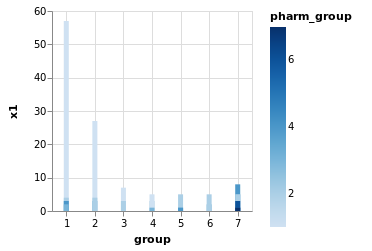

In [38]:

df |>
@vlplot(:bar,enc={x=:group,y=:x1,color=:pharm_group})

### Problem 6: Summary Statistics

Here are a few variables I think are important with a short explaination as to why I think they are important for pharmacies revenues and costs.

In [22]:
#Overall Summary Statistics

using DataFrames

rename!(census1, [x => replace(string(x), "65 years and over" => "over65")|> Symbol for x in names(census1)]); #people who ar older need to fill more perscriptions
rename!(census1, [x => replace(string(x), "Population, 2016" => "pop2016")|> Symbol for x in names(census1)]); #More people means more potential customers (and competitors)
rename!(census1, [x => replace(string(x), "Bachelor's degree" => "Bdegree")|> Symbol for x in names(census1)]); #Could represent overall wealth of the population centre
rename!(census1, [x => replace(string(x), "Employment rate" => "EmpRate")|> Symbol for x in names(census1)]); #People with jobs are more likey to be covered for perscriptions
rename!(census1, [x => replace(string(x), "Land area in square kilometres" => "Area")|> Symbol for x in names(census1)]); #people in popcentres more spaced out might be willing to
                                                                                                                        #drive farther for perscription pick up 
rename!(census1, [x => replace(string(x), "Population density per square kilometre" => "Density")|> Symbol for x in names(census1)]); #same logic as popultation 


using Statistics

vars = [:pharmacies, :over65, :pop2016, :Area, :Bdegree, :Area, :Density]

function summaryTable(census1, vars;
                      funcs=[mean, std,  x->length(collect(x))],
                      colnames=[:Variable, :Mean, :StDev, :N])
  DataFrame([vars [[f(skipmissing(df[v])) for v in vars] for f in funcs]...], colnames)  
end
summaryTable(census1, vars);

